In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

### Model Testing

rectangles[[(234, 114) (413, 293)]]
Number of faces detected: 1


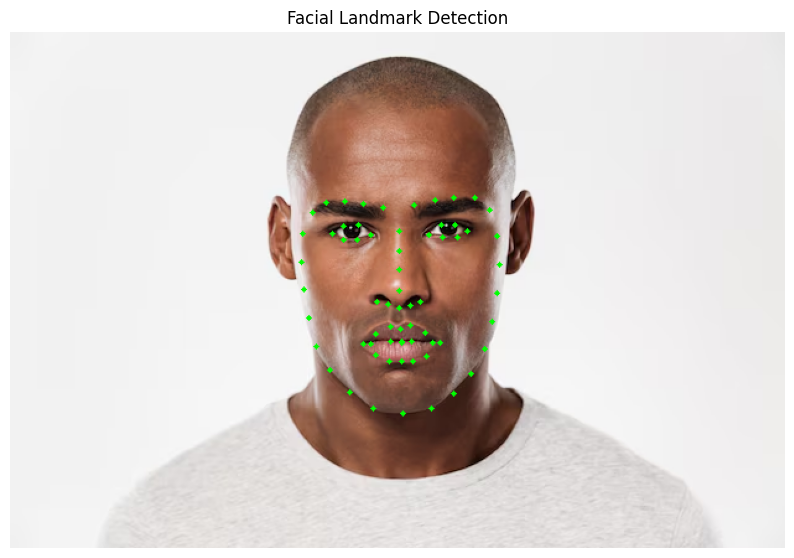

In [7]:
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
IMAGE_PATH = "./img2.png"

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# Load the image
image = cv2.imread(IMAGE_PATH)
img_copy_1 = image.copy()
img_copy_2 = image.copy()
img_copy_3 = image.copy()
left_half = image.copy()
right_half = image.copy()
if image is None:
    print(f"Image not found at {IMAGE_PATH}")
    exit()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)
print(faces)
print(f"Number of faces detected: {len(faces)}")

for face in faces:
    landmarks = predictor(gray, face)

    # Loop through each landmark point
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

# Convert image from BGR to RGB for displaying with Matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title("Facial Landmark Detection")
plt.axis('off')
plt.show()


### Identifying Nose and Eyes Midpoint

Distance from nose projection to eyes midpoint (d): 0.7908480030459941
Perpendicular distance from nose tip to eye line (D): 47.48986637043832
0.9997227549972275


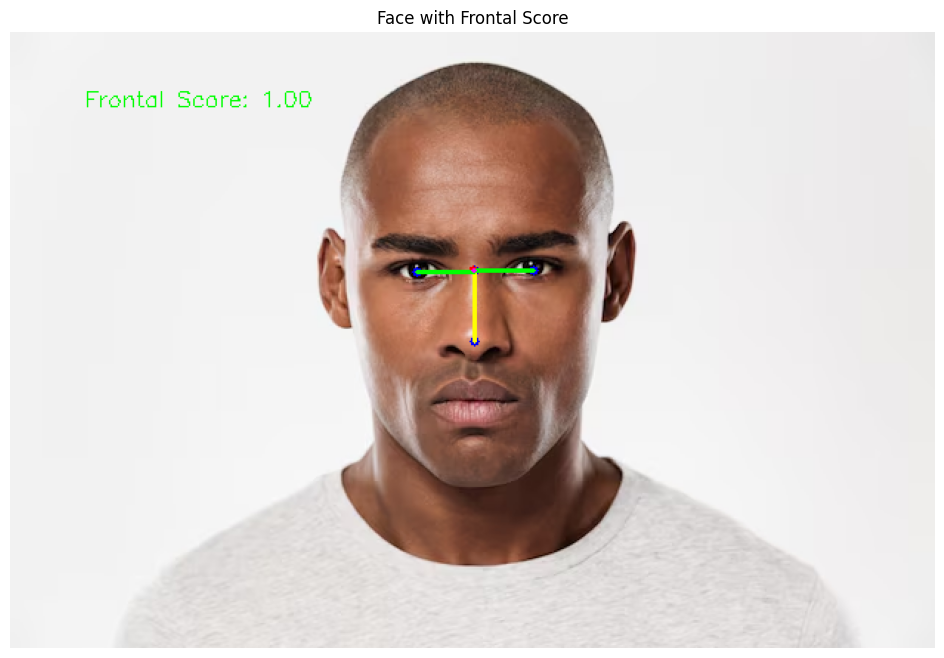

In [8]:
for face in faces:
    landmarks = predictor(gray, face)

    # Extract eye landmarks
    left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

    # Calculate the center (midpoint) of each eye
    left_eye_center = np.mean(left_eye_points, axis=0).astype(int)
    right_eye_center = np.mean(right_eye_points, axis=0).astype(int)

    # Calculate the midpoint between the two eyes
    eyes_midpoint = (
        (left_eye_center[0] + right_eye_center[0]) // 2,
        (left_eye_center[1] + right_eye_center[1]) // 2
    )

    # Nose tip (landmark 30)
    nose_tip = (landmarks.part(30).x, landmarks.part(30).y)

    # -------------------------------------------------------------------------
    # Calculate the perpendicular distance (D) from the nose tip to the line
    # connecting the eyes. This remains unchanged.
    line_vector = np.array(right_eye_center) - np.array(left_eye_center)
    line_length = np.linalg.norm(line_vector)
    perpendicular_vector = np.array([-line_vector[1], line_vector[0]])
    D = abs(np.dot((np.array(nose_tip) - np.array(left_eye_center)),
                   perpendicular_vector / line_length))
    # -------------------------------------------------------------------------

    # -------------------------------------------------------------------------
    # Compute the projection of the nose tip onto the eye line.
    # This gives us the "base" of the perpendicular dropped from the nose.
    projection_factor = np.dot(np.array(nose_tip) - np.array(left_eye_center),
                               line_vector) / (line_length ** 2)
    nose_projection = np.array(left_eye_center) + projection_factor * line_vector

    # New parameter: the distance along the eye line from the nose projection
    # (the base of the perpendicular) to the eyes' midpoint.
    d = np.linalg.norm(nose_projection - np.array(eyes_midpoint))
    # -------------------------------------------------------------------------

    print("Distance from nose projection to eyes midpoint (d):", d)
    print("Perpendicular distance from nose tip to eye line (D):", D)

    # Calculate the frontal score using the new parameter d
    frontal_score = 1 / (1 + (d / D) ** 2)
    print(frontal_score)

    # Draw points and lines for visualization
    cv2.circle(img_copy_1, nose_tip, 3, (255, 0, 0), -1)
    cv2.circle(img_copy_1, tuple(left_eye_center), 3, (255, 0, 0), -1)
    cv2.circle(img_copy_1, tuple(right_eye_center), 3, (255, 0, 0), -1)
    cv2.circle(img_copy_1, tuple(eyes_midpoint), 3, (255, 0, 0), -1)
    # Visualize the projection point (base)
    cv2.circle(img_copy_1, tuple(nose_projection.astype(int)), 3, (0, 0, 255), -1)
    # Draw lines connecting key points
    cv2.line(img_copy_1, nose_tip, eyes_midpoint, (0, 255, 255), 2)
    cv2.line(img_copy_1, tuple(left_eye_center), tuple(right_eye_center), (0, 255, 0), 2)
    cv2.line(img_copy_1, tuple(nose_projection.astype(int)), tuple(eyes_midpoint), (255, 0, 255), 2)

    # Display the frontal score on the image
    cv2.putText(
        img_copy_1,
        f"Frontal Score: {frontal_score:.2f}",
        (50, 50),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1
    )

# Convert the image from BGR to RGB for Matplotlib display
img_copy_1_rgb = cv2.cvtColor(img_copy_1, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20, 8))
plt.imshow(img_copy_1_rgb)
plt.title("Face with Frontal Score")
plt.axis('off')
plt.show()


Number of faces detected: 1
Left Half Average Coordinates: [156 208]
Right Half Average Coordinates: [469 208]


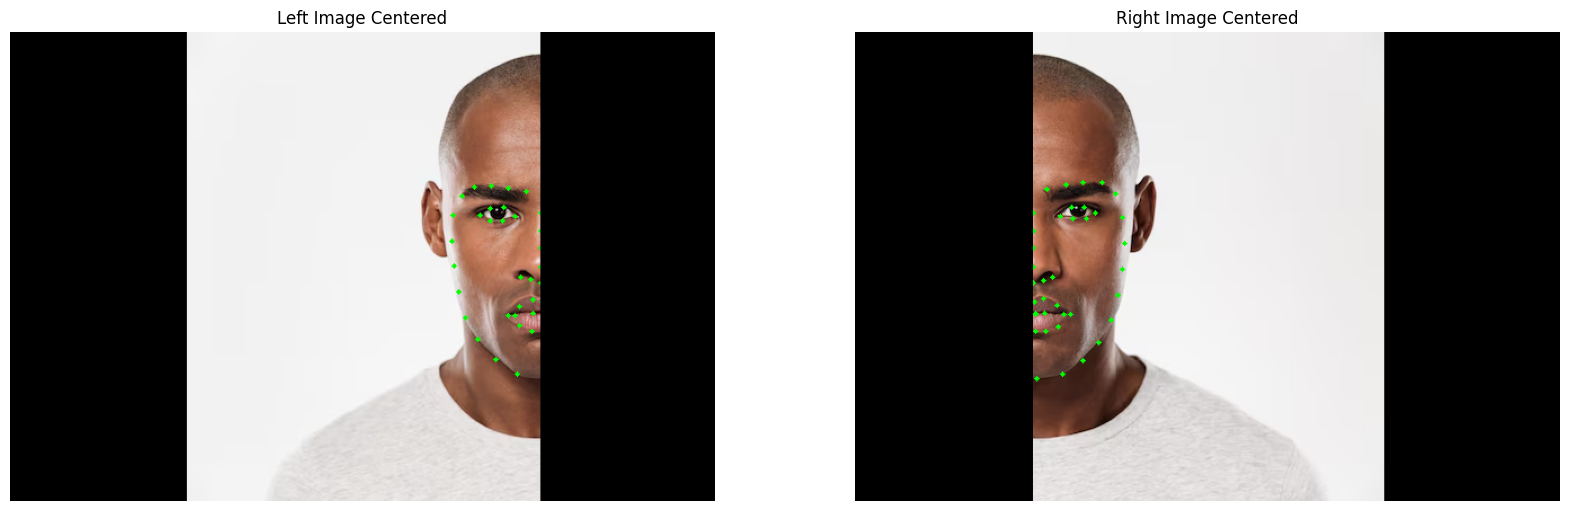

In [9]:
# Convert to grayscale
gray = cv2.cvtColor(img_copy_2, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = detector(gray)
print(f"Number of faces detected: {len(faces)}")

for face in faces:
    landmarks = predictor(gray, face)

    # Extract eye landmarks
    left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

    # Calculate the center (midpoint) of each eye
    left_eye_center = np.mean(left_eye_points, axis=0).astype(int)
    right_eye_center = np.mean(right_eye_points, axis=0).astype(int)

    # Calculate the midpoint between the two eyes
    eyes_midpoint = (
        (left_eye_center[0] + right_eye_center[0]) // 2,
        (left_eye_center[1] + right_eye_center[1]) // 2
    )

    # Nose tip
    nose_tip = (landmarks.part(30).x, landmarks.part(30).y)

    # Create masks for left and right halves
    height, width, _ = image.shape
    left_mask = np.zeros((height, width), dtype=np.uint8)
    right_mask = np.zeros((height, width), dtype=np.uint8)

    # Define the line separating left and right
    line_vector = np.array(eyes_midpoint) - np.array(nose_tip)
    perpendicular_vector = np.array([-line_vector[1], line_vector[0]])

    for y in range(height):
        for x in range(width):
            point_vector = np.array([x, y]) - np.array(nose_tip)
            side = np.dot(point_vector, perpendicular_vector)
            if side < 0:
                left_mask[y, x] = 255
            else:
                right_mask[y, x] = 255

    # Create left and right images
    left_image = cv2.bitwise_and(image, image, mask=left_mask)
    right_image = cv2.bitwise_and(image, image, mask=right_mask)

    # Calculate average positions of non-zero pixels for each half
    left_nonzero = cv2.findNonZero(left_mask)
    right_nonzero = cv2.findNonZero(right_mask)

    if left_nonzero is not None:
        left_avg = np.mean(left_nonzero, axis=0).astype(int)[0]
        diff_left = width//2 - left_avg[0]
        print(f"Left Half Average Coordinates: {left_avg}")

    if right_nonzero is not None:
        right_avg = np.mean(right_nonzero, axis=0).astype(int)[0]
        diff_right = right_avg[0] - width//2
        print(f"Right Half Average Coordinates: {right_avg}")

    # Apply affine transformation to shift images
    # Define the transformation matrix for the left image (shift right)
    M_left = np.float32([[1, 0, diff_left], [0, 1, 0]])

    # Define the transformation matrix for the right image (shift left)
    M_right = np.float32([[1, 0, -diff_right], [0, 1, 0]])

    # Apply the transformations
    left_image_shifted = cv2.warpAffine(left_image, M_left, (width, height))
    right_image_shifted = cv2.warpAffine(right_image, M_right, (width, height))

    # Display the shifted images
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(left_image_shifted, cv2.COLOR_BGR2RGB))
    plt.title("Left Image Centered")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(right_image_shifted, cv2.COLOR_BGR2RGB))
    plt.title("Right Image Centered")
    plt.axis('off')

    plt.show()


Number of faces detected: 1


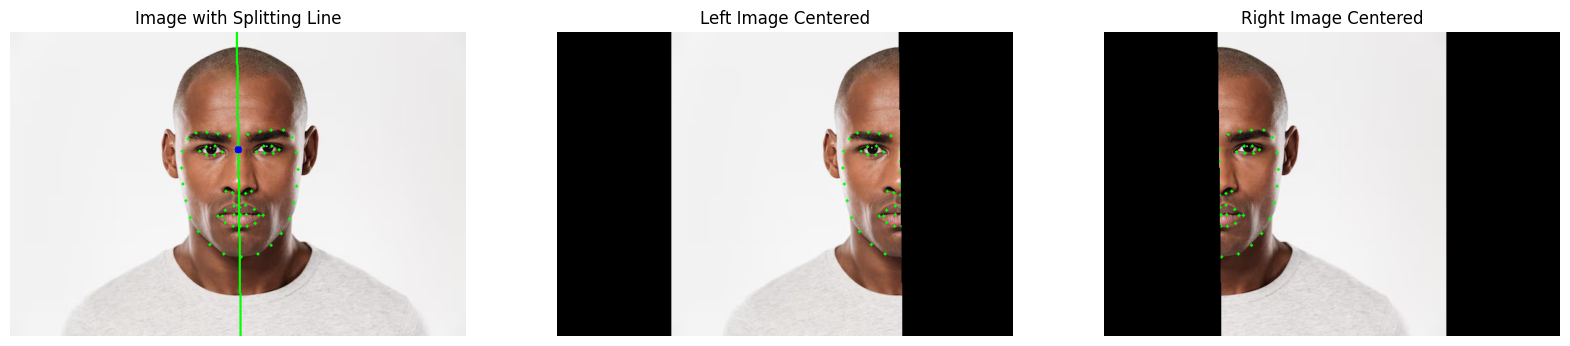

In [10]:

# Convert to grayscale for landmark detection
gray = cv2.cvtColor(img_copy_3, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = detector(gray)
print(f"Number of faces detected: {len(faces)}")

for face in faces:
    landmarks = predictor(gray, face)

    # --- Extract and compute eye landmarks ---
    # Left eye: landmarks 36-41, Right eye: landmarks 42-47
    left_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
    right_eye_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]

    # Compute the centers of the eyes
    left_eye_center = np.mean(left_eye_points, axis=0).astype(int)
    right_eye_center = np.mean(right_eye_points, axis=0).astype(int)

    # Midpoint between the two eyes (eyeline midpoint)
    eyes_midpoint = (
        (left_eye_center[0] + right_eye_center[0]) // 2,
        (left_eye_center[1] + right_eye_center[1]) // 2
    )

    # Nose tip (landmark 30)
    nose_tip = (landmarks.part(30).x, landmarks.part(30).y)

    # --- Compute the reference points for splitting ---
    # 1. Eye connecting vector (from left to right eye)
    eye_line = np.array(right_eye_center) - np.array(left_eye_center)
    eye_line_length = np.linalg.norm(eye_line)
    if eye_line_length == 0:
        continue  # Avoid division by zero

    # 2. Project the nose tip onto the eye line
    projection_factor = np.dot(np.array(nose_tip) - np.array(left_eye_center), eye_line) / (eye_line_length ** 2)
    nose_projection = np.array(left_eye_center) + projection_factor * eye_line

    # 3. Compute the splitting point as the midpoint between the eyes_midpoint and the nose projection
    split_point = (nose_projection + np.array(eyes_midpoint)) / 2

    # --- Define the splitting line and its normal ---
    # The splitting line should be perpendicular to the eye connecting line.
    # For classification (left/right), we use a normal vector that is parallel to the eye line.
    n = eye_line / eye_line_length  # normalized eye_line (points left/right)
    # For drawing purposes, the splitting line's direction (which is perpendicular to n) is:
    v = np.array([-n[1], n[0]])

    # --- Create masks for left and right halves ---
    height, width, _ = image.shape
    left_mask = np.zeros((height, width), dtype=np.uint8)
    right_mask = np.zeros((height, width), dtype=np.uint8)

    # For each pixel, decide its side based on the dot product with the normal vector n.
    # This dot product essentially checks the horizontal (left/right) offset from the split_point.
    for y in range(height):
        for x in range(width):
            pt = np.array([x, y])
            # If the dot product is negative, assign the pixel to the left mask.
            if np.dot(pt - split_point, n) < 0:
                left_mask[y, x] = 255
            else:
                right_mask[y, x] = 255

    left_image = cv2.bitwise_and(image, image, mask=left_mask)
    right_image = cv2.bitwise_and(image, image, mask=right_mask)

    # --- (Optional) Recentering each half ---
    left_nonzero = cv2.findNonZero(left_mask)
    right_nonzero = cv2.findNonZero(right_mask)

    if left_nonzero is not None:
        left_avg = np.mean(left_nonzero, axis=0).astype(int)[0]
        diff_left = width // 2 - left_avg[0]
    else:
        diff_left = 0

    if right_nonzero is not None:
        right_avg = np.mean(right_nonzero, axis=0).astype(int)[0]
        diff_right = right_avg[0] - width // 2
    else:
        diff_right = 0

    # Define affine transformations to shift each half horizontally (centering)
    M_left = np.float32([[1, 0, diff_left], [0, 1, 0]])
    M_right = np.float32([[1, 0, -diff_right], [0, 1, 0]])

    left_image_shifted = cv2.warpAffine(left_image, M_left, (width, height))
    right_image_shifted = cv2.warpAffine(right_image, M_right, (width, height))

    # --- (Optional) Draw the splitting line on a copy of the image for visualization ---
    line_length = max(width, height)
    pt1 = (int(split_point[0] + v[0] * line_length), int(split_point[1] + v[1] * line_length))
    pt2 = (int(split_point[0] - v[0] * line_length), int(split_point[1] - v[1] * line_length))
    image_with_line = image.copy()
    cv2.line(image_with_line, pt1, pt2, (0, 255, 0), 2)
    cv2.circle(image_with_line, (int(split_point[0]), int(split_point[1])), 5, (255, 0, 0), -1)

    # --- Display the results ---
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image_with_line, cv2.COLOR_BGR2RGB))
    plt.title("Image with Splitting Line")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(left_image_shifted, cv2.COLOR_BGR2RGB))
    plt.title("Left Image Centered")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(right_image_shifted, cv2.COLOR_BGR2RGB))
    plt.title("Right Image Centered")
    plt.axis('off')

    plt.show()
